In [32]:
# Imports and setup
import scanpy as sc
import numpy as np
import pandas as pd
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi =300,facecolor="white")
from __future__ import annotations
import anndata as ad
import pooch

In [33]:
# Create data manager object using pooch library
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_tutorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/",
)
EXAMPLE_DATA.load_registry_from_doi()

In [34]:
# Creating AnnData object
samples ={
    "sld1": "s1d1_filtered_feature_bc_matrix.h5",
    "sld3": "s1d3_filtered_feature_bc_matrix.h5",
}
adatas = {}

for sample_id, filename in samples.items():
    path = EXAMPLE_DATA.fetch(filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label='sample')
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())
adata

reading /Users/harshadingle/Library/Caches/scverse_tutorials/s1d1_filtered_feature_bc_matrix.h5
 (0:00:00)
reading /Users/harshadingle/Library/Caches/scverse_tutorials/s1d3_filtered_feature_bc_matrix.h5


/opt/miniconda3/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/miniconda3/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)
sample
sld1    8785
sld3    8340
Name: count, dtype: int64


/opt/miniconda3/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/miniconda3/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/miniconda3/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 17125 × 36601
    obs: 'sample'

In [35]:
# Quality Control for identifying mitochondrial, ribosomal and hemoglobin genes
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)

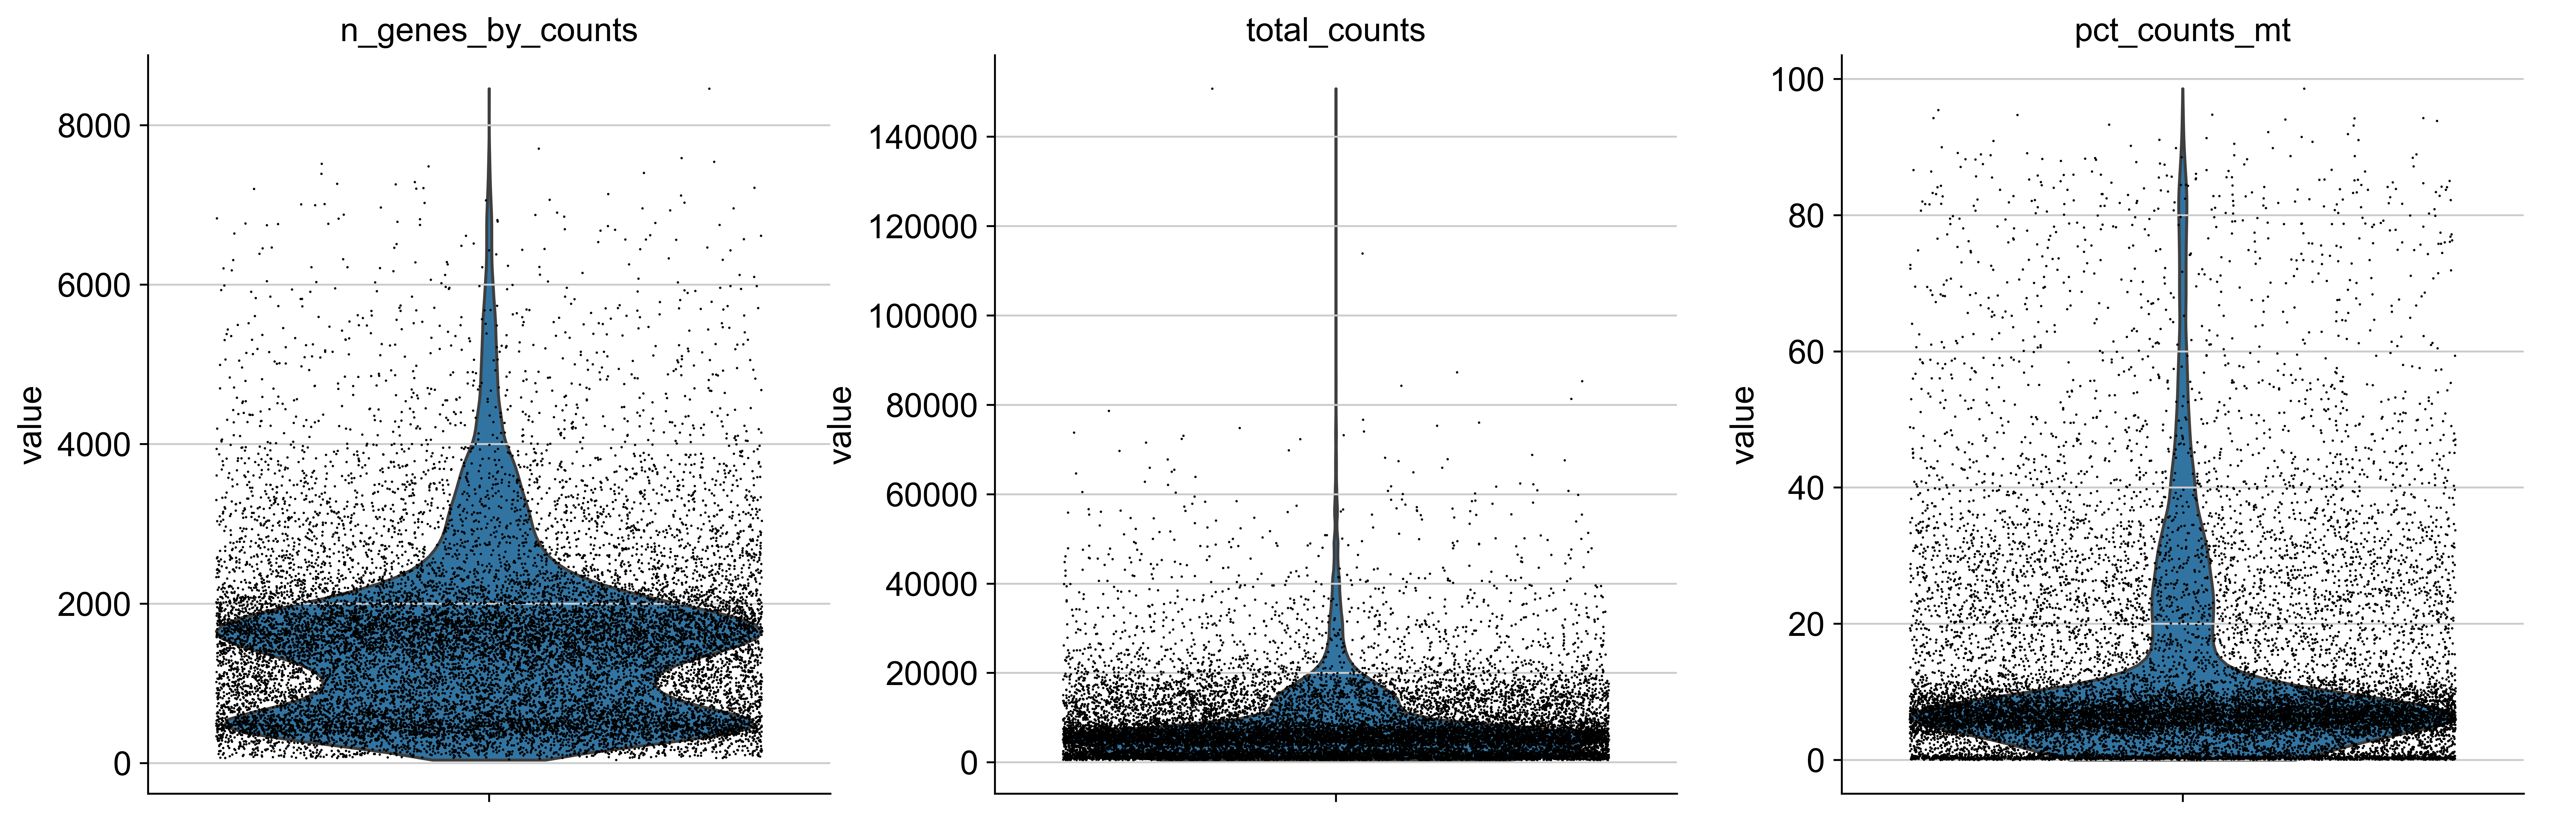

In [36]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
    save=".svg"
)

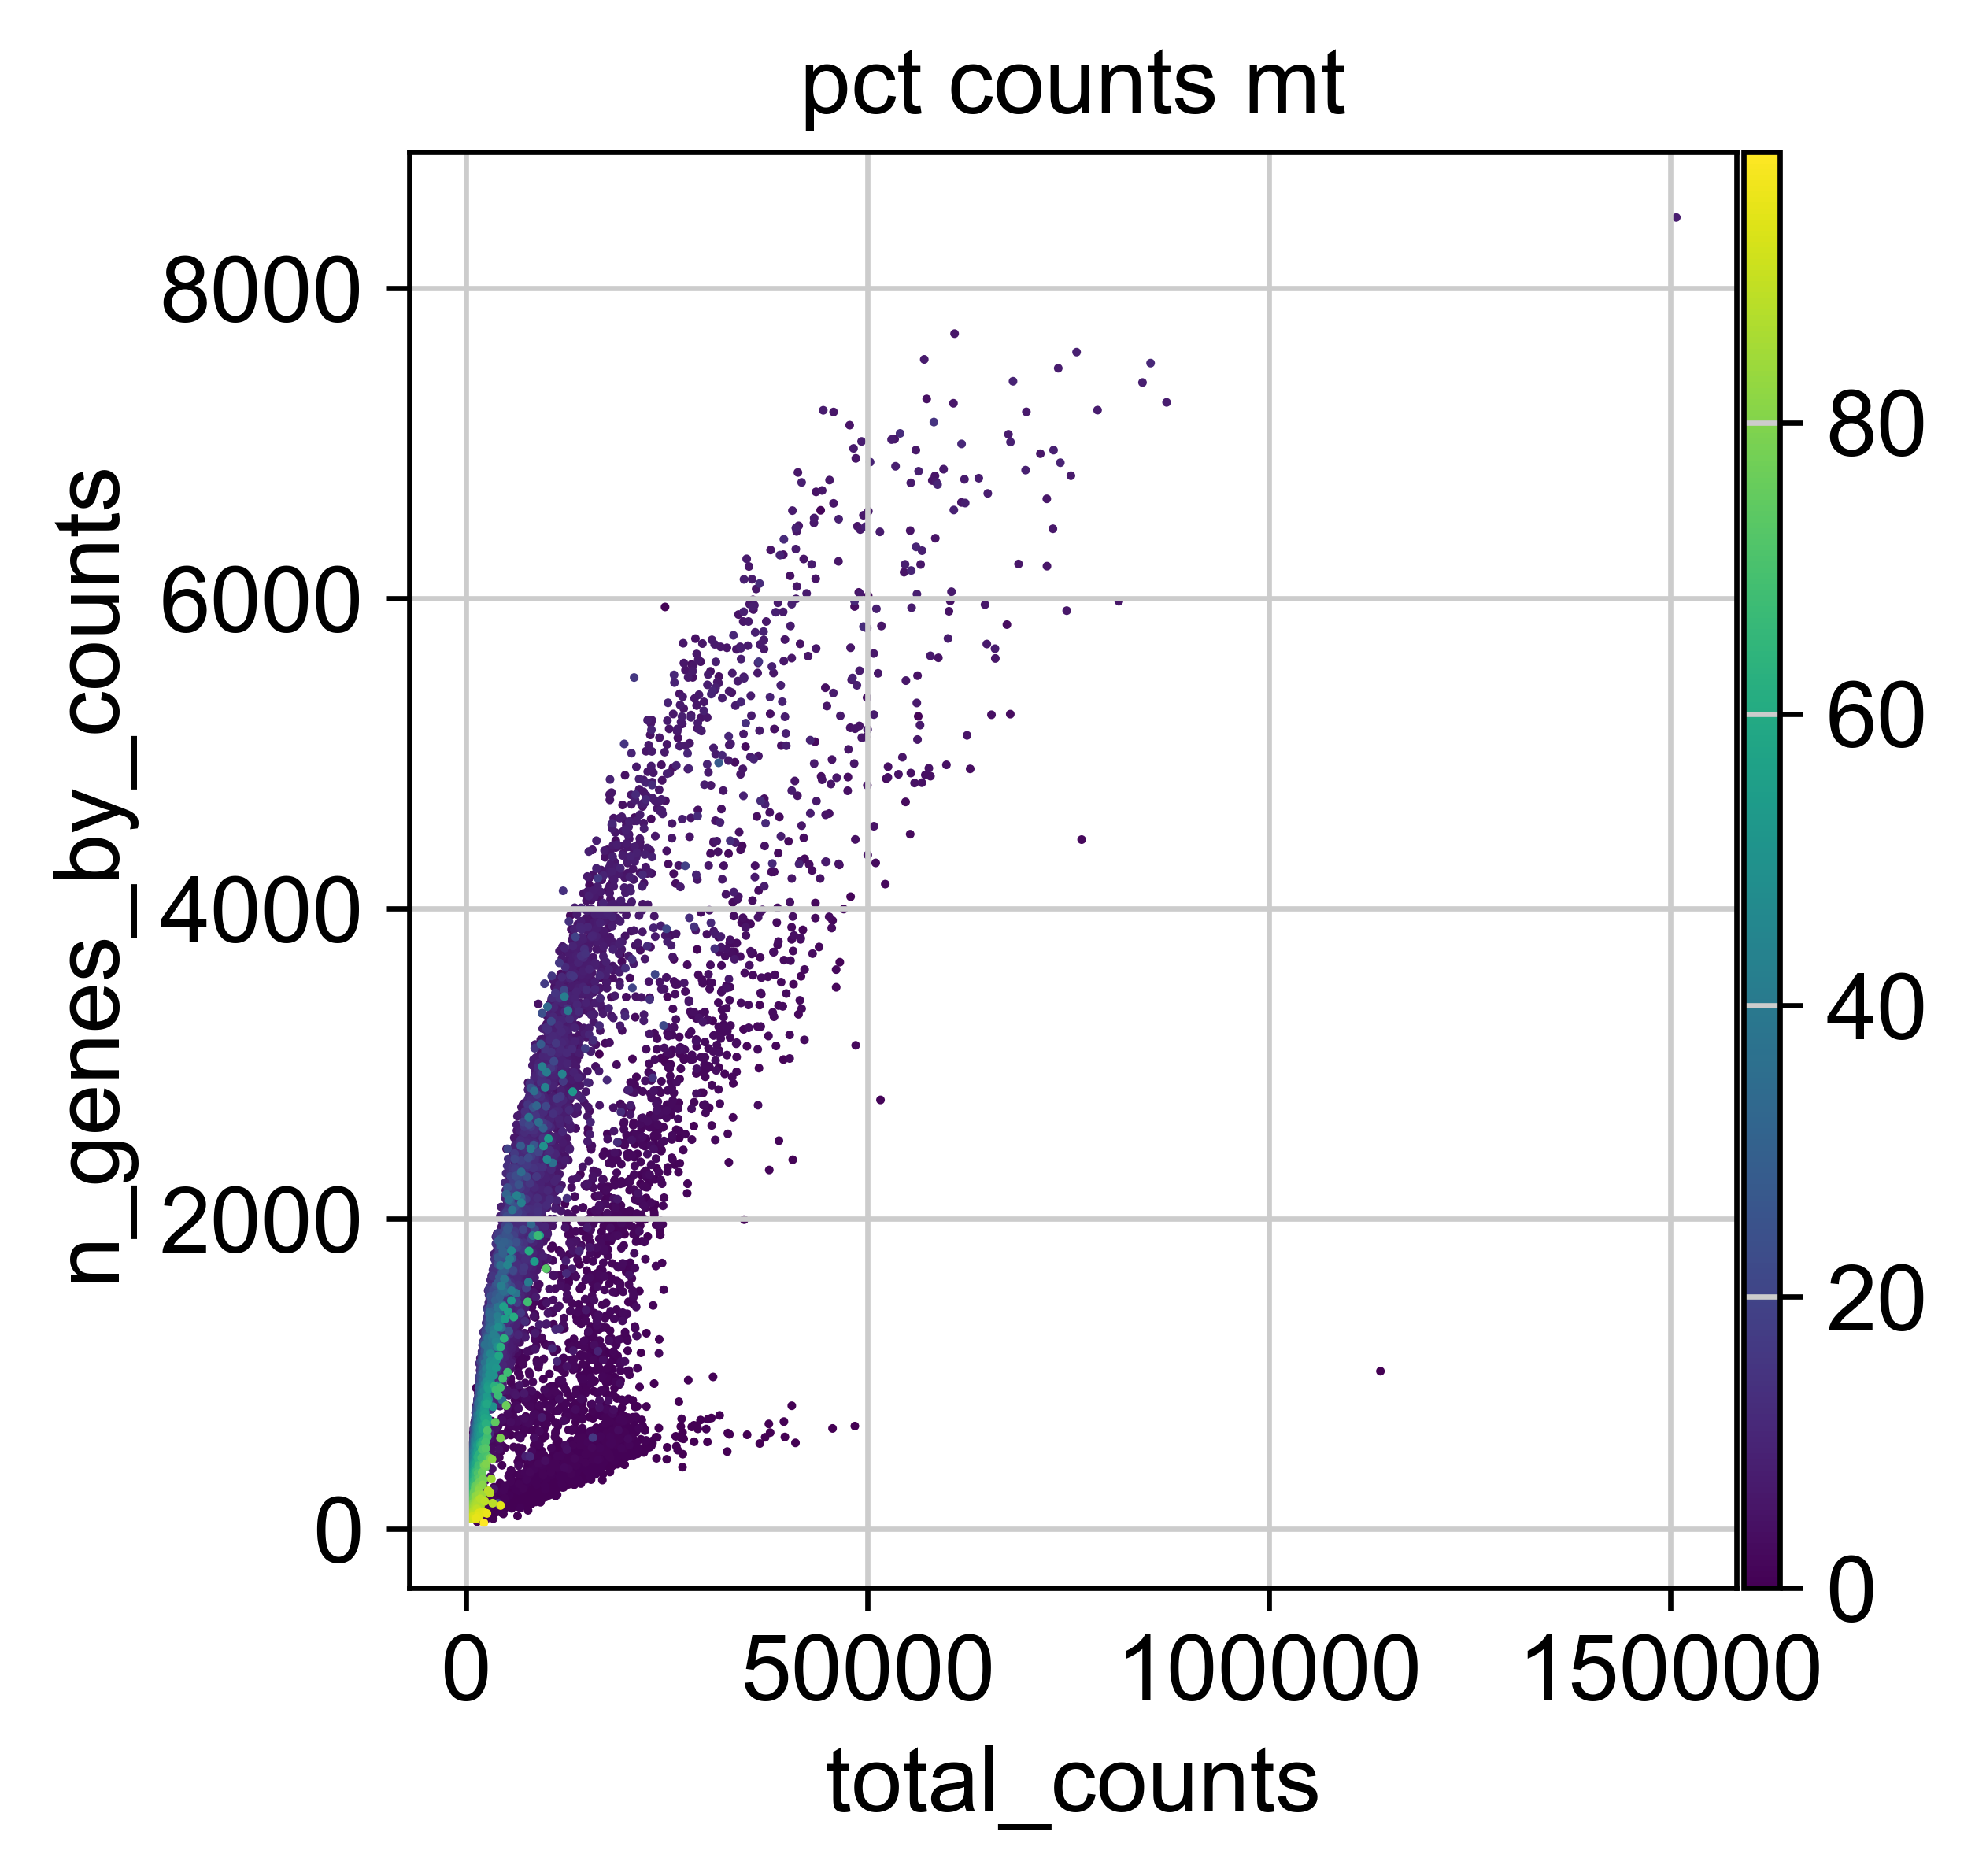

In [37]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [38]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 84 cells that have less than 100 genes expressed
filtered out 13174 genes that are detected in less than 3 cells


In [39]:
# Doublet detection
# Needs scikit-image. Install using conda-forge before running the command.
sc.pp.scrublet(adata, batch_key="sample")
# 2. Filter out predicted doublets
adata = adata[~adata.obs["predicted_doublet"]].copy()
# 3. Check remaining cells
print(f"Remaining cells after filtering doublets: {adata.n_obs}")

Running Scrublet
filtered out 1752 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    using data matrix X directly
Automatically set threshold at doublet score = 0.22
Detected doublet rate = 2.4%
Estimated detectable doublet fraction = 32.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 7.4%
filtered out 2029 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata

In [40]:
# Normalization
# Saving count data
adata.layers["counts"] = adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


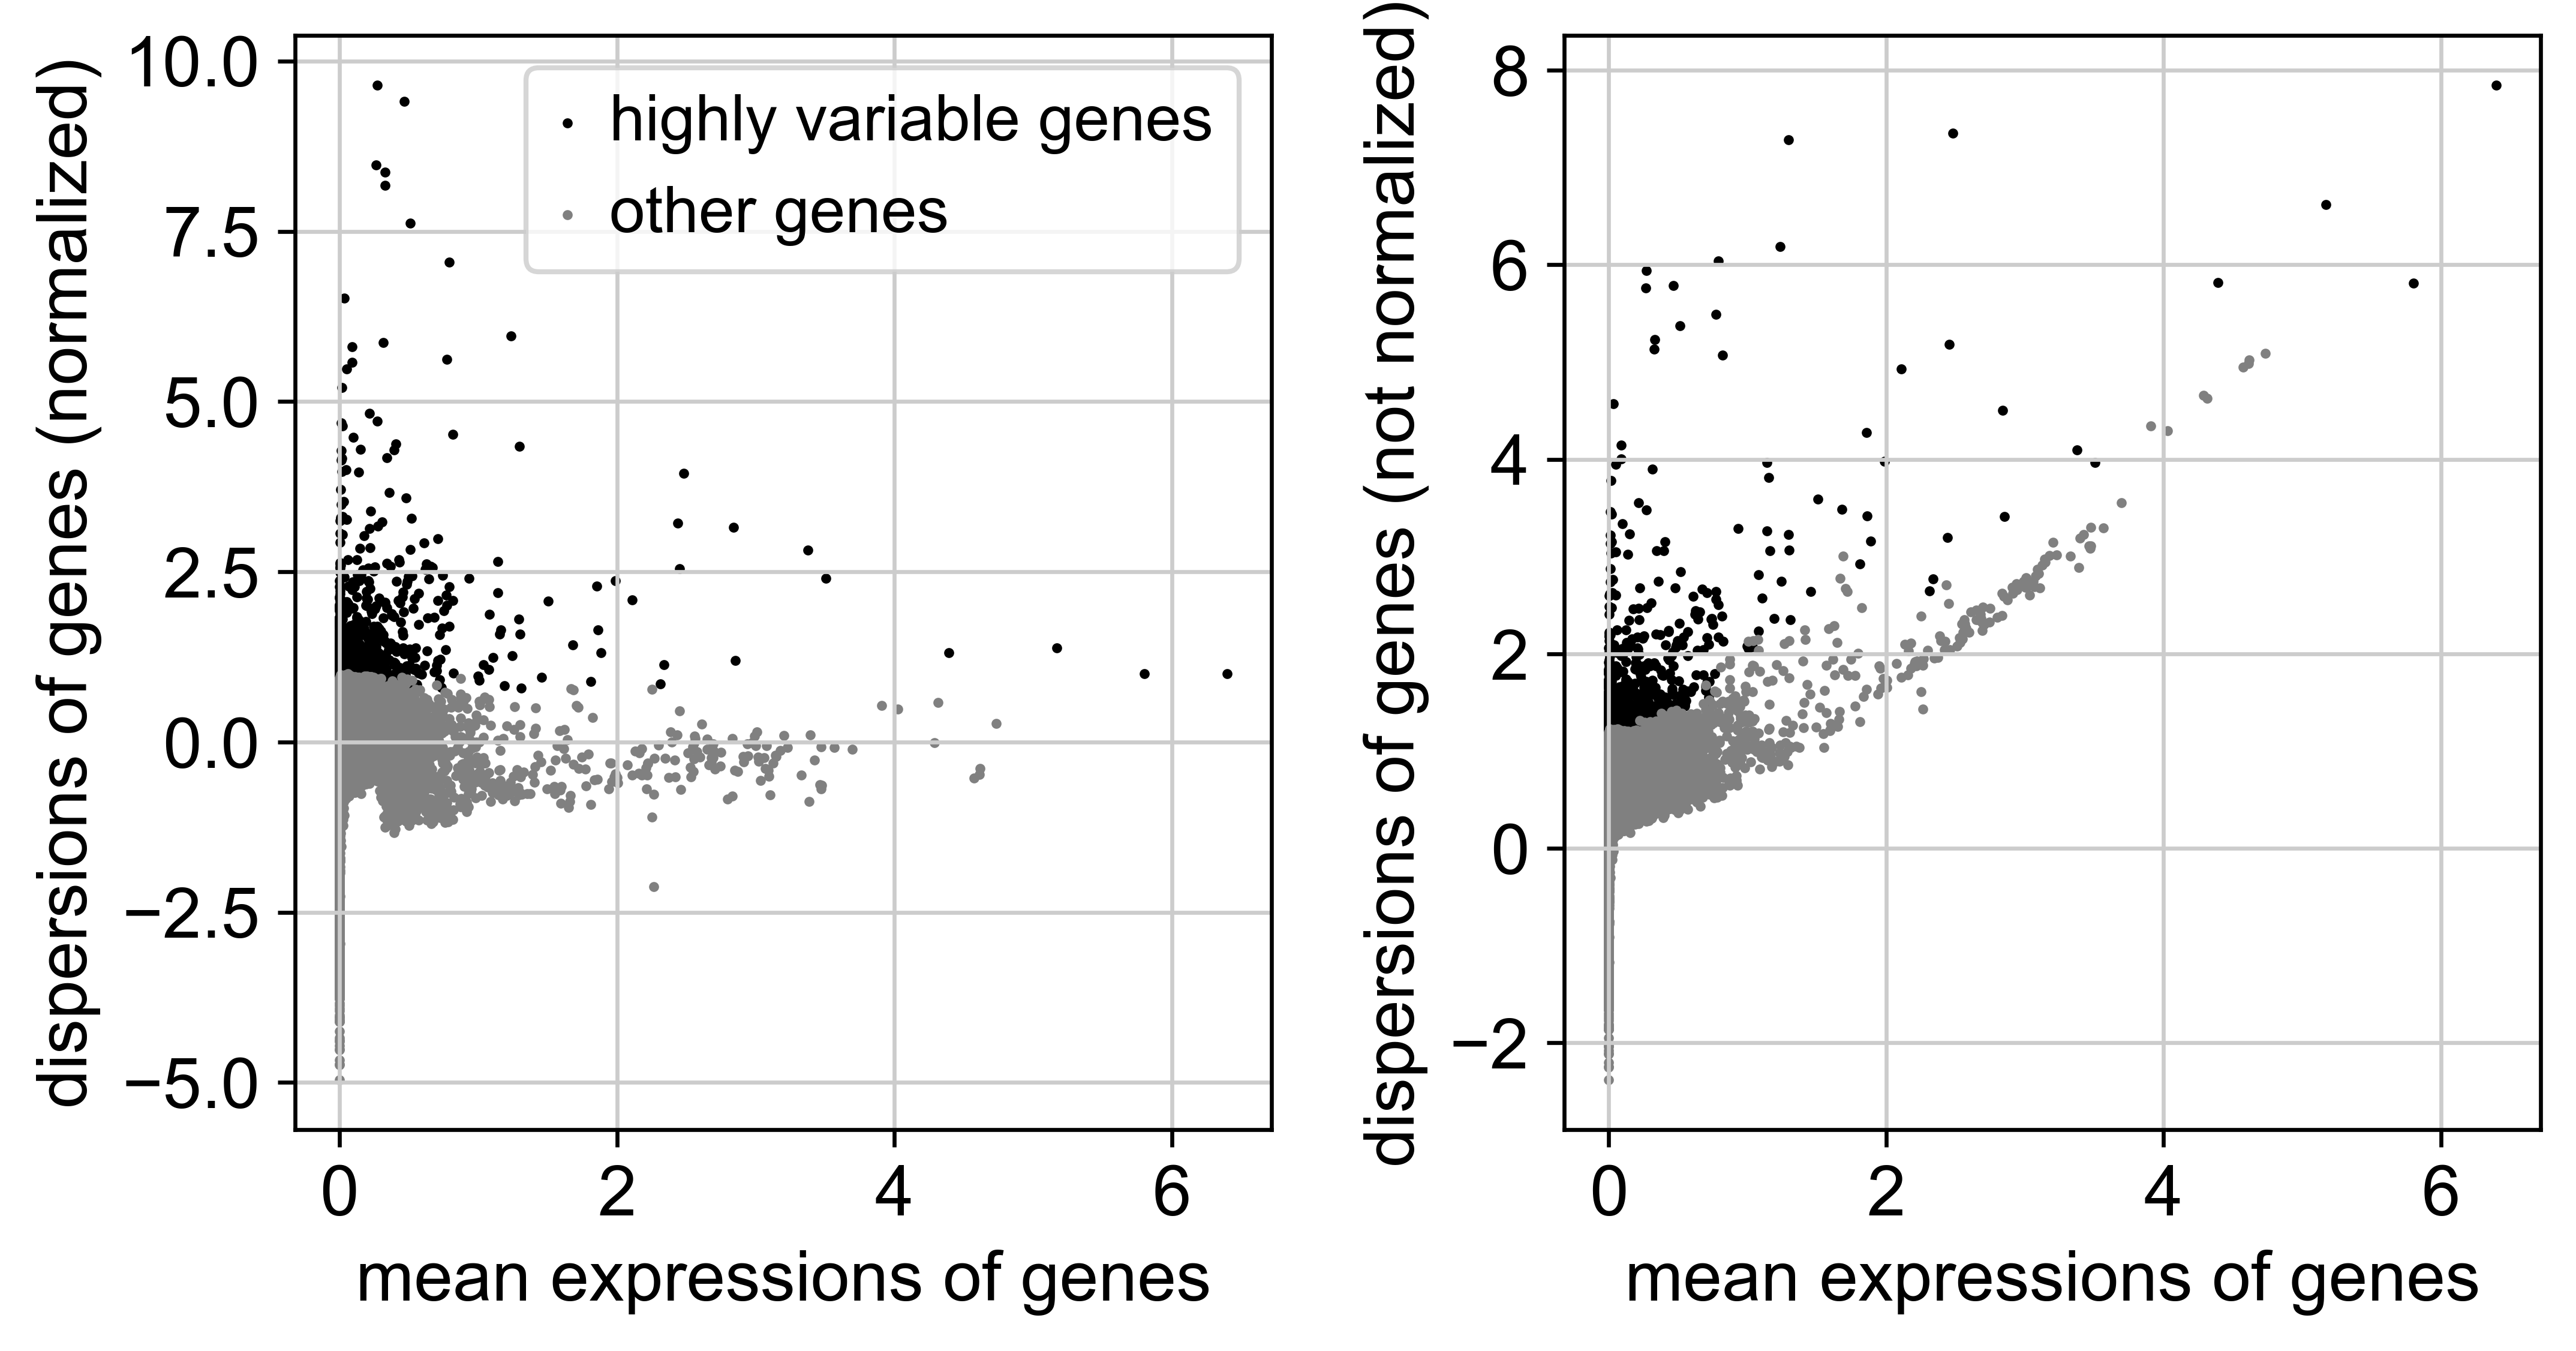

In [41]:
# Feature selection
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")
sc.pl.highly_variable_genes(adata)

In [ ]:
adata.var.head()
adata.var['highly_variable'].value_counts()  # number of True/False genes
adata.var.sort_values('highly_variable', ascending=False).head(10)
adata.var.sort_values('means', ascending=False).head(10)

mt   ribo     hb  n_cells_by_counts  mean_counts  \
HBB      False  False   True              17116  1602.894423   
MALAT1   False  False  False              16958   245.870482   
HBA2     False  False   True              16788   468.788380   
MT-ATP6   True  False  False              17003    74.212088   
MT-CO3    True  False  False              16960    75.031299   
MT-CO1    True  False  False              17076    77.603270   
MT-CO2    True  False  False              16951    69.766599   
HBA1     False  False   True              15092   212.890920   
MT-ND3    True  False  False              16722    51.159650   
MT-CYB    True  False  False              16801    48.174073   

         log1p_mean_counts  pct_dropout_by_counts  total_counts  \
HBB               7.380190               0.052555    27449562.0   
MALAT1            5.508864               0.975182     4210532.0   
HBA2              6.152282               1.967883     8028001.0   
MT-ATP6           4.320312               0.712409     1270882.0   
MT-CO3            4.331145               0.963504     1284911.0   
MT-CO1            4.364413               0.286131     1328956.0   
MT-CO2            4.259387               1.016058     1194753.0   
HBA1              5.365466              11.871533     3645757.0   
MT-ND3            3.954309               2.353285      876109.0   
MT-CYB            3.895367               1.891971      824981.0   

         log1p_total_counts  n_cells  highly_variable     means  dispersions  \
HBB               17.127861    17032             True  6.397937     7.845669   
MALAT1            15.253099    16883             True  5.800667     5.809630   
HBA2              15.898446    16711             True  5.171554     6.617628   
MT-ATP6           14.055223    16927            False  4.734810     5.088069   
MT-CO3            14.066201    16887            False  4.618683     5.023810   
MT-CO1            14.099905    17001            False  4.613431     4.984856   
MT-CO2            13.993451    16879            False  4.572612     4.947299   
HBA1              15.109075    15031             True  4.393426     5.819311   
MT-ND3            13.683247    16652            False  4.316066     4.627496   
MT-CYB            13.623116    16728            False  4.288300     4.658412   

         dispersions_norm  highly_variable_nbatches  \
HBB              1.000000                         1   
MALAT1           1.000000                         1   
HBA2             1.384941                         1   
MT-ATP6          0.269826                         0   
MT-CO3          -0.388453                         0   
MT-CO1          -0.473562                         0   
MT-CO2          -0.531932                         0   
HBA1             1.315073                         2   
MT-ND3           0.578295                         0   
MT-CYB          -0.005361                         0   

         highly_variable_intersection  
HBB                             False  
MALAT1                          False  
HBA2                            False  
MT-ATP6                         False  
MT-CO3                          False  
MT-CO1                          False  
MT-CO2                          False  
HBA1                             True  
MT-ND3                          False  
MT-CYB                          False

computing PCA
    with n_comps=50
    finished (0:00:00)


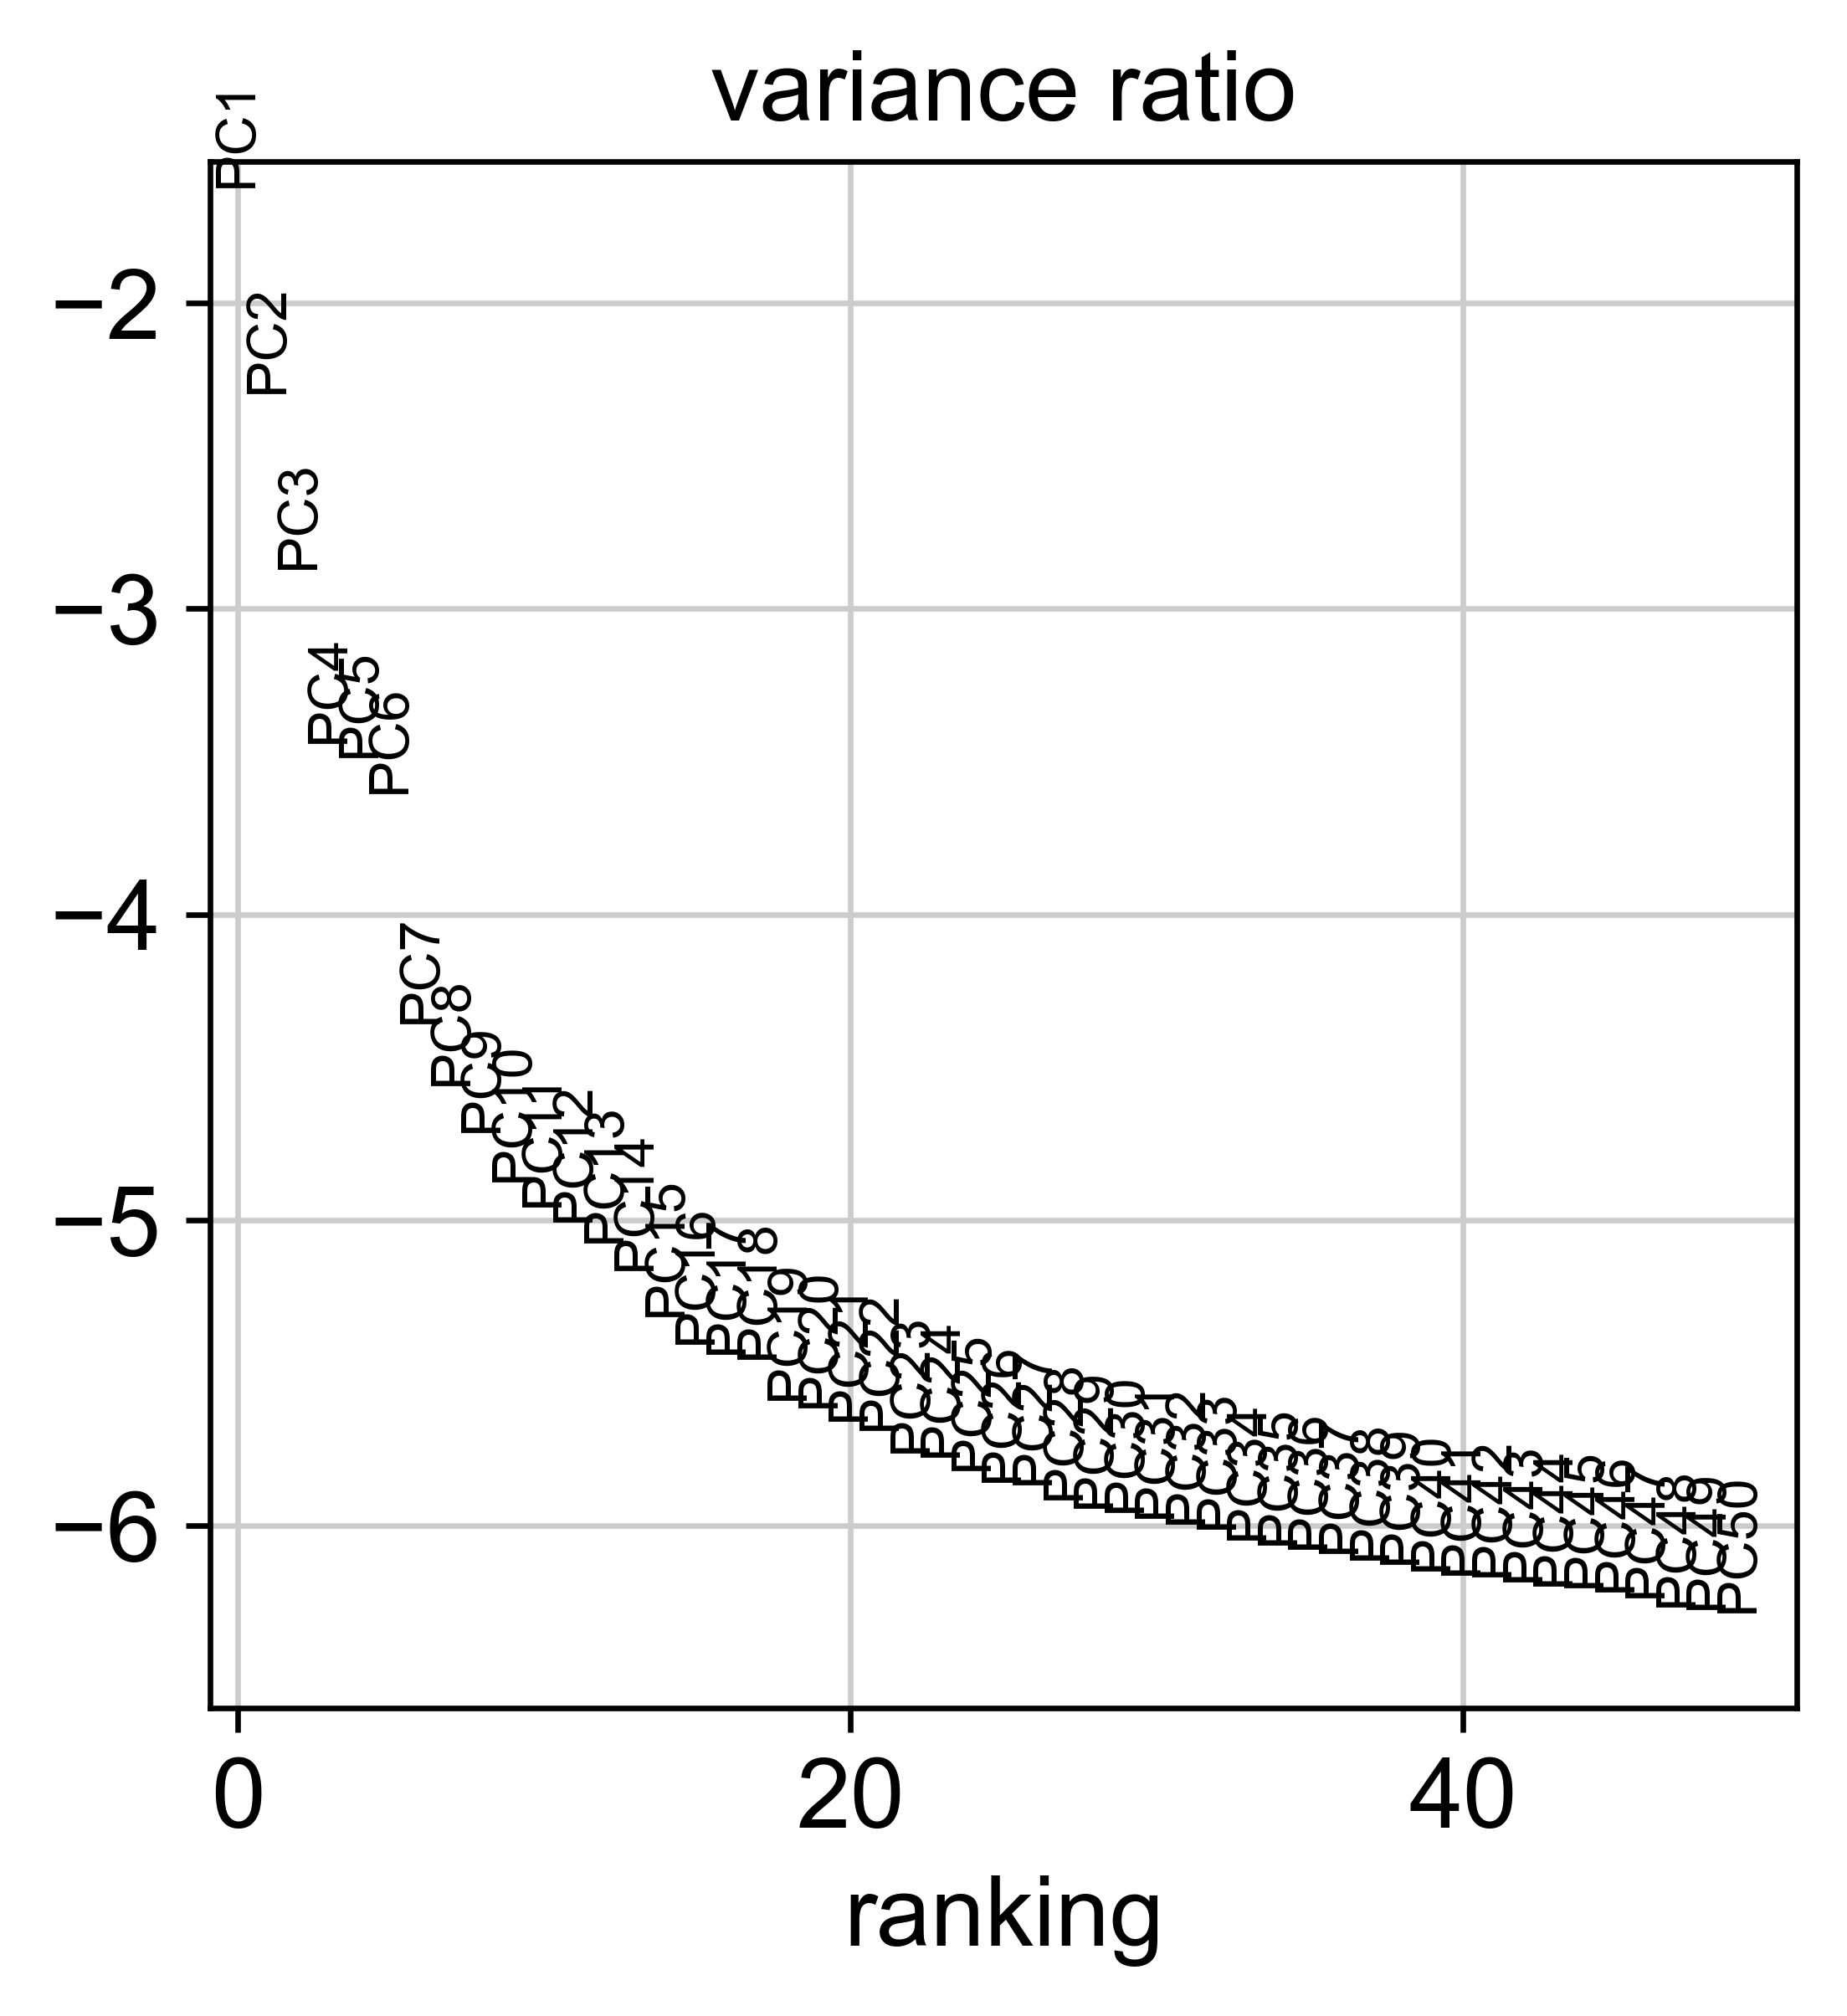

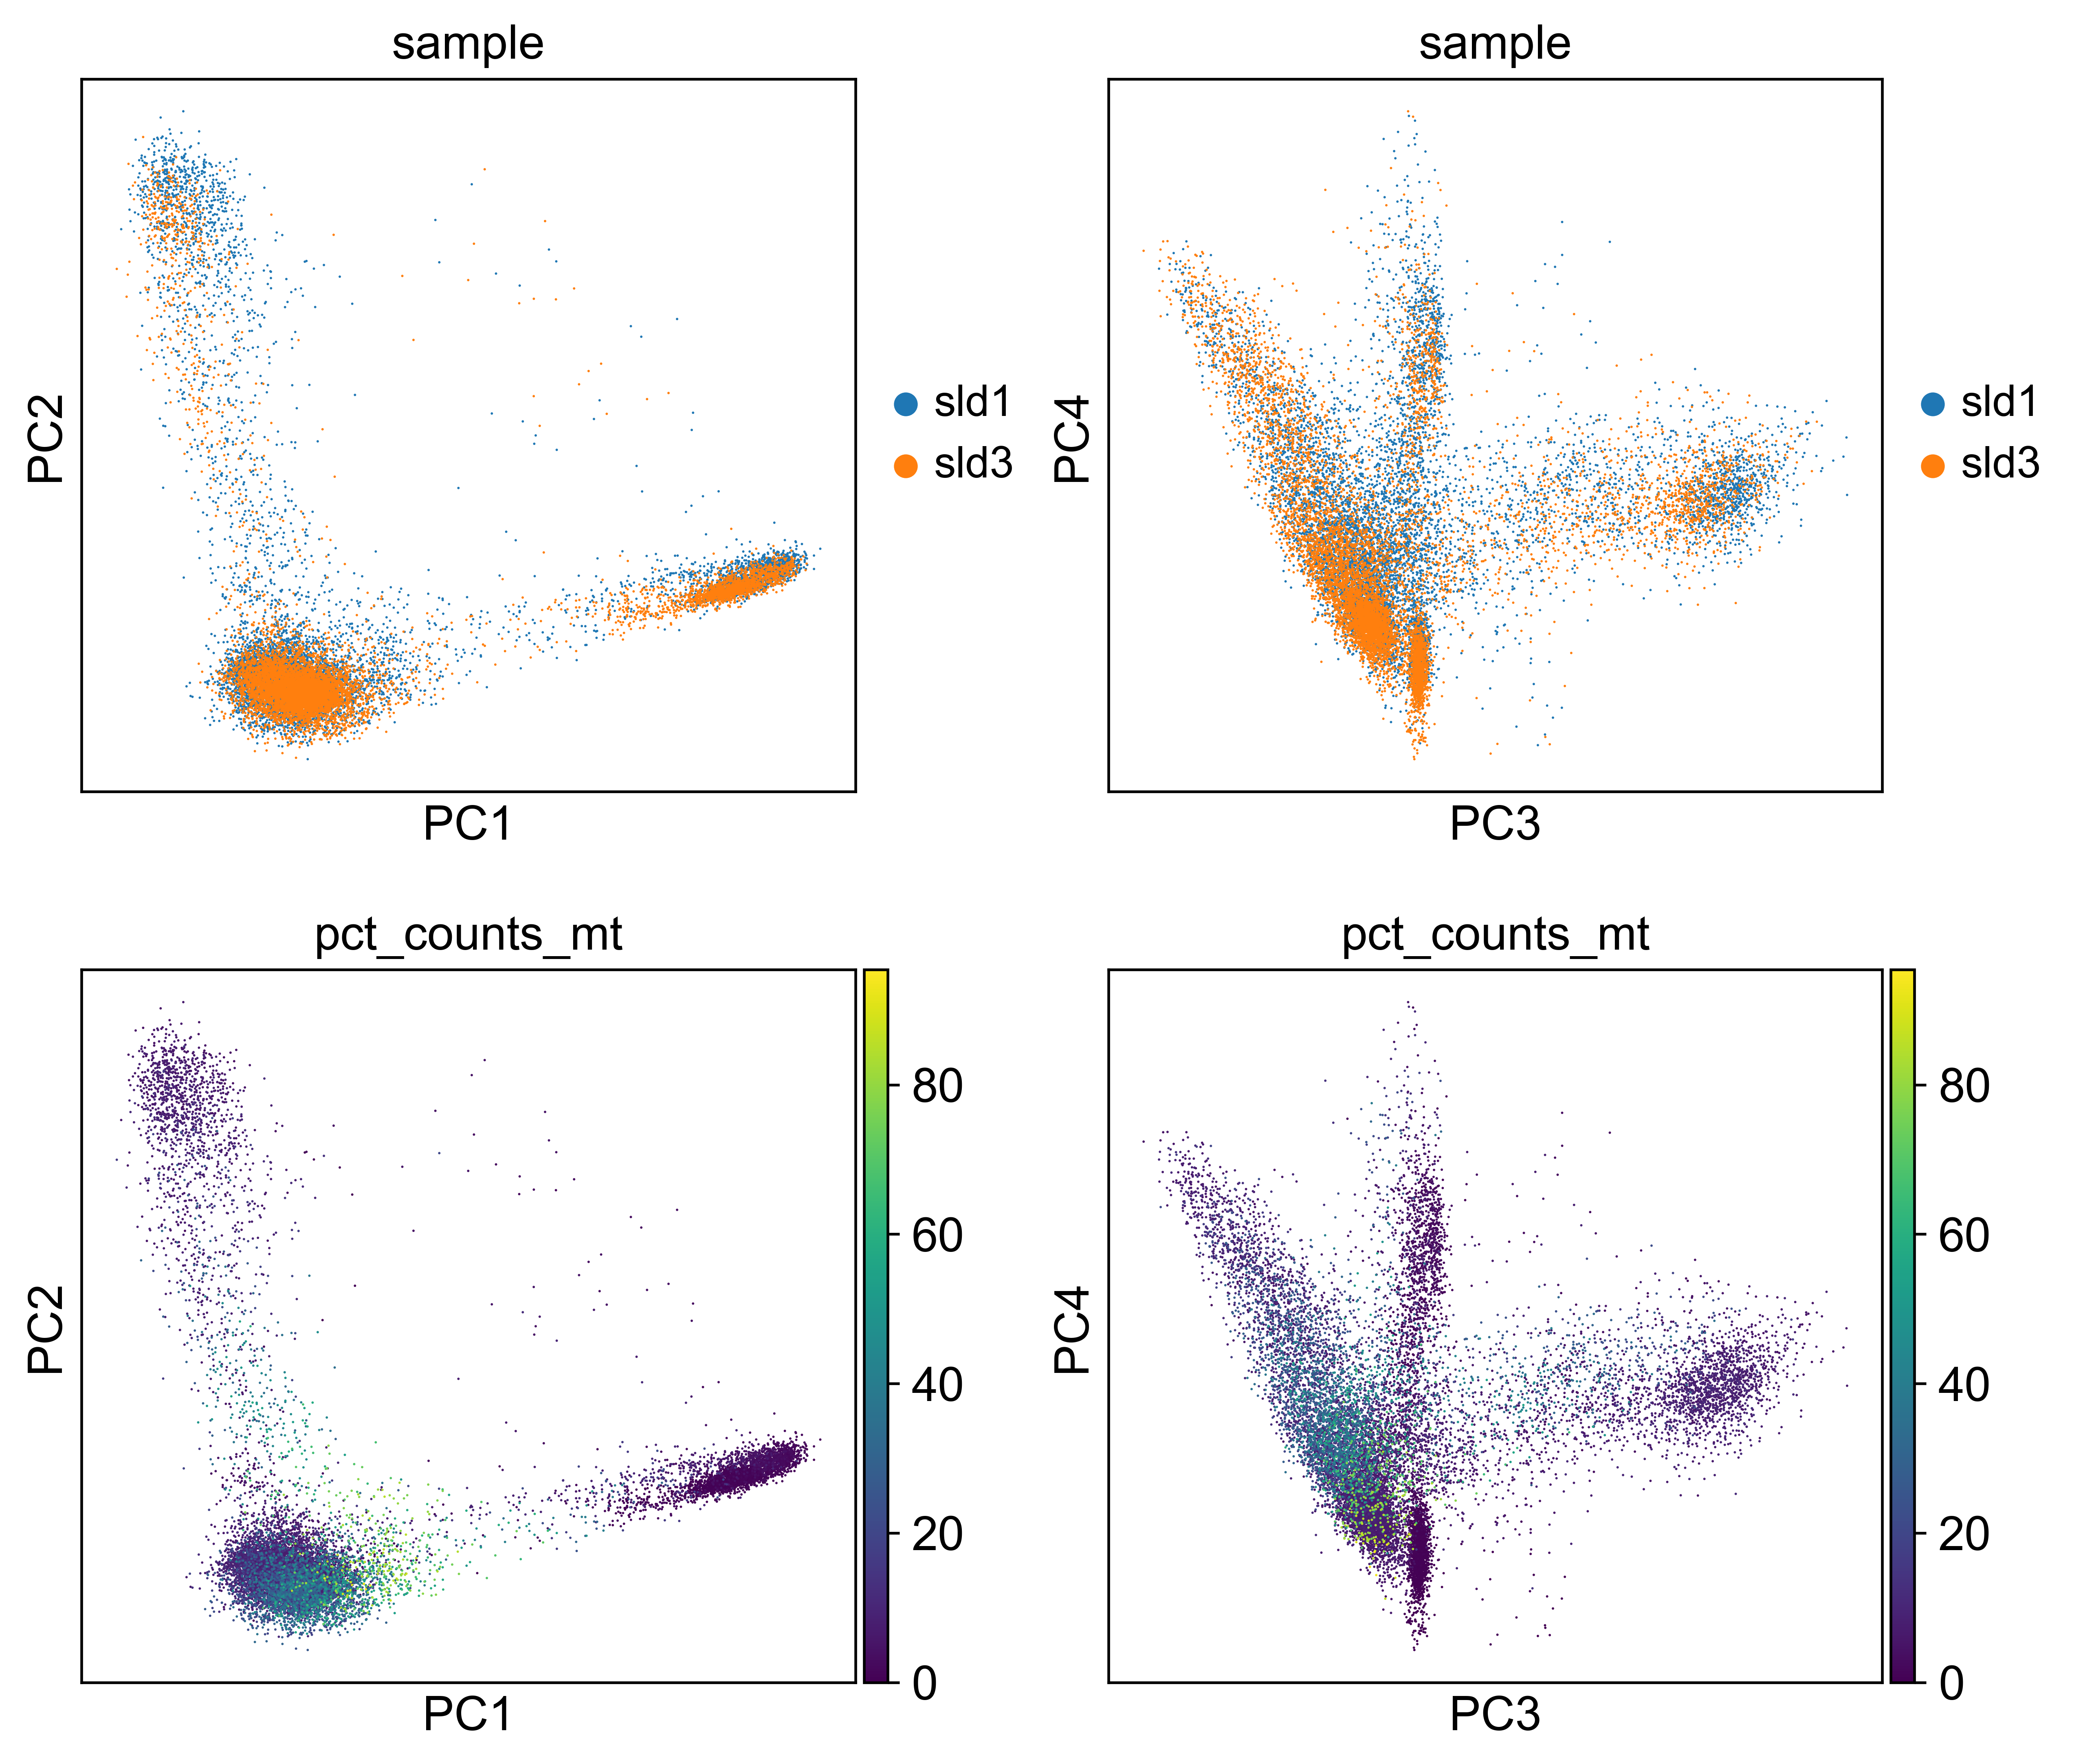

In [47]:
# Dimension reduction
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)
sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)